# Project: Quantification of Geometric Brownian Motion (GBM) Prediction of Equity Price Data

## Background
[Geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is a continuous-time stochastic process model in which the random variable $S(t)$, e.g., the share price of `XYZ` is described by a deterministic drift corrupted by a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process):

$$\frac{dS}{S} = {\mu}dt + \sigma{dW}$$

The constant $\mu$ denotes a drift parameter, $\sigma$ indicates a volatility parameter, and $dW$ represents the output of a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process).  Using [Ito's lemma](https://en.wikipedia.org/wiki/Itô%27s_lemma), we can formulate an analytical solution to the GBM equation:

$$S(t) = S_{\circ}\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})\cdot{Z(0,1)}\Biggr]$$

where $S_{\circ}$ denotes the sharte price at $t_{\circ}$, and $Z(0,1)$ denotes a [standard normal random variable](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution). 

## Learning Objectives
In this project, students will test the _in sample_ effectiveness of the Geometric Brownian Motion (GBM) as a predictive approach for the forward projection of equity share price. 

* __Objective__: Quantify GBM model prediction rate by comparing historical data for different periods and firms with model predictions. Compute the probability of a `successful` prediction for each firm. 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the geometric Brownian motion simulation of equity share prices.

The mutable struct `MyGeometricBrownianMotionEquityModel`, which holds the parameters associated with the geometric Brownian motion simulation, has two fields:
* The `μ::Float64` field holds the drift or growth parameter for the model
* The `σ::Float64` field holds the volatility parameter for the model

### Functions
The `Include.jl` file also loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`function loaddatafile(; firm::Int = 1, year::String = "Year-1") -> DataFrame` 
 > The `loaddatafile(...)` function, which load historical share price data, takes an [Int](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/#Integers) that encodes a `firm index` and a [String](https://docs.julialang.org/en/v1/manual/strings/) argument that holds the `year` parameter of the dataset. The historical share price data is returned to the caller as a [DataFrame](https://dataframes.juliadata.org/stable/) with the fields: `volume`,`volume_weighted_average_price`,`open`,`close`,`high`, and `low,number_of_transactions`.

`function generate_firm_index_set() -> Set{Int64}`
> The `generate_firm_index_set()` function generates the set of `firm_id` values for which we have data files for all the years of this study, i.e., `Year-1,..., Year-5`. 

`function build(model::Type{MyGeometricBrownianMotionEquityModel}, data::NamedTuple) -> MyGeometricBrownianMotionEquityModel` 
> The `build)(...)` function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the $(\mu, \sigma)$ values) and returns an instance of the `MyGeometricBrownianMotionEquityModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types). 

`function solve(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple; number_of_paths::Int64 = 100) -> Array{Float64,2}`
> The `solve(...)` function takes a `MyGeometricBrownianMotionEquityModel` instance, and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and solves the geometric Brownian motion model for `number_of_paths` (default: 100) trials. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

`function 𝔼(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple) -> Array{Float64,2}`
> The `𝔼(...)` functions takes a `MyGeometricBrownianMotionEquityModel` instance and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and computes the expectation of the share price as a function of time. The expectation is returned as a `T`$\times$`2` array where the first column holds the time values while the second column holds the expected share price. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

`Var(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple)`
> The `Var(...)` function takes a `MyGeometricBrownianMotionEquityModel` instance and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and computes the variance of the share price as a function of time. The variance is returned as a `T`$\times$`2` array where the first column holds the time values while the second column holds the expected share price. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3`


## Prerequisite: Load and Clean the Historical Price Dataset

We load the Open High Low Close (OHLC) data files for all firms for `Year-1 ... Year-5` using the `loaddatafile(...)` function. This function returns a `DataFrame` holding a year’s worth of data (approximately 252 records). Since we are loading multiple years of data for each firm, we combine all the annual `DataFrame` instances into a single `DataFrame` using the [DataFrame append! function](https://docs.juliahub.com/DataFrames/AR9oZ/0.21.5/lib/functions/#Base.append!). We store the combined `DataFrames` in the `dataset` dictionary where keys corresponding to the `firm_id`:

In [2]:
dataset = Dict{Int64,DataFrame}();
set_of_firms = generate_firm_index_set();

years = ["Year-1", "Year-2", "Year-3", "Year-4", "Year-5"];
while (isempty(set_of_firms) == false)
    firm_index = pop!(set_of_firms)
    
    for year ∈ years
        tmp_data = loaddatafile(firm=firm_index, year=year);
        
        if (haskey(dataset,firm_index) == false)
            dataset[firm_index] = tmp_data;
        else
            append!(dataset[firm_index], tmp_data)
        end
    end
end

Not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or were delisted, etc. We will exclude these firms from the `dataset`.

#### Implementation
First, we specify the `max_number_of_records` variable, which holds the number of trading records we expect for each firm, in this case, `1256`. Then, we iterate through the firms in the `dataset` using a `for` loop. We remove those firms from the `dataset` whose row count (calculated by calling the `nrow(...)` function) is not equal to the `max_number_of_records`; a firm is removed from the `dataset` using the [delete! function](https://docs.julialang.org/en/v1/base/collections/#Base.delete!):

In [3]:
max_number_of_records = 1256
number_of_firms = length(dataset)
for (firm_index, data) ∈ dataset
    data = dataset[firm_index];
    
    if (nrow(data) != max_number_of_records)
        delete!(dataset, firm_index);
    end
end

list_of_firm_ids = keys(dataset) |> collect |> sort;
number_of_firms = length(list_of_firm_ids);

Finally, we've computed the geometric brownian motion model parameters $(\mu,\sigma)$ for each firm in the dataset and stored these values in a text file. We load the model parameters using the `loadmodelparametersfile()` function which returns a `DataFrame` of parameters, which we store in the `parameters` variable:

In [4]:
parameters = loadmodelparametersfile();

#### Test
Specify a `test_firm_index` and the number of days `T` we’ll simulate. Then create a model `MyGeometricBrownianMotionEquityModel` instance, and solve the model. If all is working, you should see a time projection of the share price of `323` for `T = 48` days:

In [5]:
test_firm_index = 323;
T = 48
Δt = (1.0/252.0);
firm_data = dataset[test_firm_index];
μ̂ = parameters[parameters.firm .== test_firm_index, :μ] |> first;
σ̂ = parameters[parameters.firm .== test_firm_index, :σ] |> first;
    
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

start_index = 300
stop_index = start_index + T


Sₒ = firm_data[start_index,:volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt

X = solve(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

expectation = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

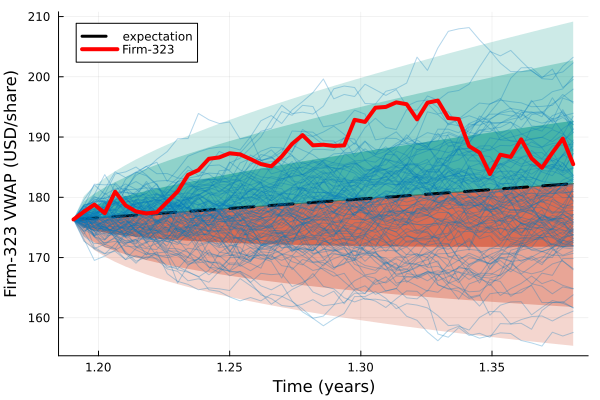

In [6]:
L68 = expectation[:,2] .- sqrt.(variance[:,2])
U68 = expectation[:,2] .+ sqrt.(variance[:,2])
L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])


plot(expectation[:,1], expectation[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")

plot!(expectation[:,1], expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
plot!(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.3)
plot!(X[:,1], firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
    label="Firm-$(test_firm_index)")

xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(test_firm_index) VWAP (USD/share)", fontsize=18)

## Objective: Quantify the _in sample_ Geometric Motion Model (GBM) Prediction Rate
This objective will test the prediction capability of the GBM model. To accomplish this, we will (randomly) divide time into contiguous intervals $\mathcal{I}_{k}\in\mathcal{I}$ of length `T` days. At the start of each interval $\mathcal{I}_{k}$, we will construct GBM model using the `build(…)` function. Then, we will compute the expectation and variance of the share price using the `𝔼(...)` and `Var(...)` functions for $t_{j}\in\mathcal{I}_{k}$, starting from the known share price. 

* If the simulated price falls between a lower bound $L_{j}$ and an upper bound $U_{j}$ for all $t_{j}\in\mathcal{I}_{k}$, the simulation is considered a `success`. The lower $L_{j}$ and upper $U_{j}$ bounds can be specified. However, by default, they are set to $\mu\pm{2.576}\cdot\sigma$, where $\mu$ is the expected value and $\sigma$ is the standard deviation of the share price predcited by the GBM simulation.
* However, if the actual price violates either the lower or upper bound at any point, the simulation is deemed a `failure`.

First, specify the length of each time interval (in days) in the `T` variable:

In [7]:
T = 21;

Next, we partition time into random intervals $\mathcal{I}_{k}\in\mathcal{I}$. We define the `date_range_set`, which holds time intervals $\mathcal{I}_{k}$, and populate this set using a `while` loop. For each pass of the loop, we randomly generate a `start_index`, and then compute a `stop_index` by adding the number of trading days `T` to the `start_index`. We continue iterating until we have generated `number_of_date_ranges` in $\mathcal{I}$, i.e., $\dim\mathcal{I}=$`number_of_date_ranges`:

In [8]:
date_range_set = Set{StepRange{Int64, Int64}}();
number_of_date_ranges = 500;
counter = 0
while (counter < number_of_date_ranges)
    
    start_index = rand(1:(max_number_of_records - T - 1))
    stop_index = start_index + T
    range(start_index, stop=stop_index, step=1) |> (x-> push!(date_range_set, x))
    
    counter = length(date_range_set);
end

### Simulation
The hidden simulation code block evaluates every firm in the `dataset` for each time interval in the `date_range_set`. It produces two data structures: 

* The `success_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()` is the [Set](https://docs.julialang.org/en/v1/base/collections/#Base.Sethttps://docs.julialang.org/en/v1/base/collections/#Base.Set) that contains the `firm_id` and the time interval that has passed the bounds test encoded as a [Julia Tuple](https://docs.julialang.org/en/v1/manual/functions/#Tupleshttps://docs.julialang.org/en/v1/manual/functions/#Tuples).
* The `failed_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()` is the [Set](https://docs.julialang.org/en/v1/base/collections/#Base.Sethttps://docs.julialang.org/en/v1/base/collections/#Base.Set) that contains the `firm_id` and the time interval that has `failed` the bounds test encoded as a [Julia Tuple](https://docs.julialang.org/en/v1/manual/functions/#Tupleshttps://docs.julialang.org/en/v1/manual/functions/#Tuples)

In [9]:
success_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()
failed_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()
for firm_id ∈ list_of_firm_ids
    
    firm_data = dataset[firm_id];
    μ̂ = parameters[parameters.firm .== firm_id, :μ] |> first;
    σ̂ = parameters[parameters.firm .== firm_id, :σ] |> first;
    
    model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));
    
    date_range_set_copy = deepcopy(date_range_set)
    while (isempty(date_range_set_copy) == false)
        
        date_range = pop!(date_range_set_copy);
        start_index = first(date_range)
        stop_index = last(date_range)
        
        Sₒ = firm_data[start_index, :volume_weighted_average_price];
        T₁ = start_index*Δt
        T₂ = stop_index*Δt
        
        expectation = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
        variance = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
        
        L = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
        U = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])
   
        success_flag = true;
        for k ∈ 1:T
            if (firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
                success_flag = false;
                break;
            end
        end
        
        position_tuple = (firm_id, date_range)
        if (success_flag == true)
            push!(success_simulation_set, position_tuple);
        else
            push!(failed_simulation_set, position_tuple);
        end
    end 
end

#### Visualize a random `successful` simulation:

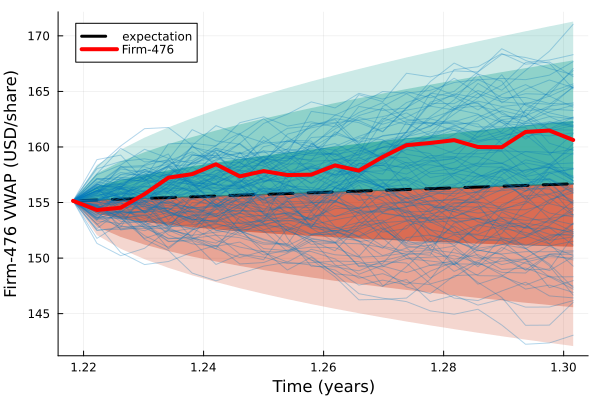

In [10]:
result_tuple_success = rand(success_simulation_set)
firm_id_success = result_tuple_success |> first;
firm_data_success = dataset[firm_id_success];

date_range = result_tuple_success |> last;
start_index = first(date_range)
stop_index = last(date_range)

Sₒ = firm_data_success[start_index, :volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt
        
μ̂ = parameters[parameters.firm .== firm_id_success, :μ] |> first;
σ̂ = parameters[parameters.firm .== firm_id_success, :σ] |> first;

model_success = build(MyGeometricBrownianMotionEquityModel, (
        μ = μ̂, σ = σ̂ ));

expectation_success = 𝔼(model_success, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance_success  = Var(model_success, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

X = solve(model_success, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

 # draw the plot -
L68 = expectation_success[:,2] .- sqrt.(variance_success[:,2])
U68 = expectation_success[:,2] .+ sqrt.(variance_success[:,2])
L95 = expectation_success[:,2] .- 1.96*sqrt.(variance_success[:,2])
U95 = expectation_success[:,2] .+ 1.96*sqrt.(variance_success[:,2])
L99 = expectation_success[:,2] .- 2.576*sqrt.(variance_success[:,2])
U99 = expectation_success[:,2] .+ 2.576*sqrt.(variance_success[:,2])

plot(expectation_success[:,1], expectation_success[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")
plot!(expectation_success[:,1], expectation_success[:,2],c=:black, lw=3,ls=:dash, label="expectation")
plot!(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.3)
plot!(X[:,1], firm_data_success[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
    label="Firm-$(firm_id_success)")

xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(firm_id_success) VWAP (USD/share)", fontsize=18)

#### Visualize a random `failed` simulation:

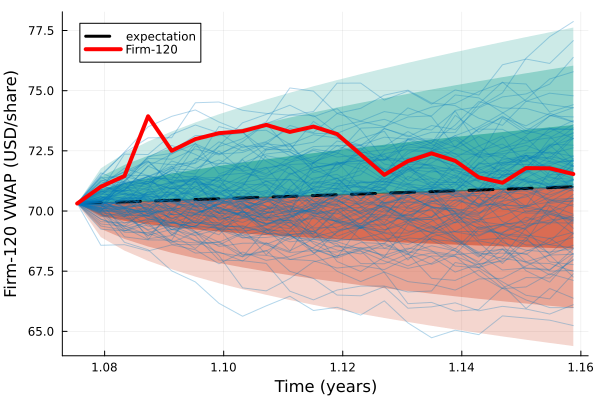

In [11]:
result_tuple_failed = rand(failed_simulation_set)
firm_id_failed = result_tuple_failed |> first;
firm_data_failed = dataset[firm_id_failed];

date_range = result_tuple_failed |> last;
start_index = first(date_range)
stop_index = last(date_range)

Sₒ = firm_data_failed[start_index, :volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt

model_failed = build(MyGeometricBrownianMotionEquityModel, (
        μ = μ̂, σ = σ̂ ));
        
expectation_failed = 𝔼(model_failed, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance_failed  = Var(model_failed, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

X = solve(model_failed, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

 # draw the plot -
L68 = expectation_failed[:,2] .- sqrt.(variance_failed[:,2])
U68 = expectation_failed[:,2] .+ sqrt.(variance_failed[:,2])
L95 = expectation_failed[:,2] .- 1.96*sqrt.(variance_failed[:,2])
U95 = expectation_failed[:,2] .+ 1.96*sqrt.(variance_failed[:,2])
L99 = expectation_failed[:,2] .- 2.576*sqrt.(variance_failed[:,2])
U99 = expectation_failed[:,2] .+ 2.576*sqrt.(variance_failed[:,2])

plot(expectation_failed[:,1], expectation_failed[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2],c=:black, lw=3,ls=:dash, label="expectation")
plot!(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.3)
plot!(X[:,1], firm_data_failed[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
    label="Firm-$(firm_id_failed)")

xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(firm_id_failed) VWAP (USD/share)", fontsize=18)

### Compute the probability of success $p_{+}$ for each firm
To determine the likelihood of the geometric Brownian motion (GBM) model succeeding on a random time interval, we examine the `successful_simulation_set` and estimate the probability that the GBM model can successfully predict equity prices in a random time interval. Store the probability of `success` in the `probability_dictionary` where the `keys` of the dictionary are the `firm_id` values and the `values` are the probability of a successful prection $p_{+}$: 

In [12]:
probability_dictionary = Dict{Int64, Float64}()
for success_case ∈ success_simulation_set
    
    firm_id = success_case |> first;
    if (haskey(probability_dictionary, firm_id) == false)
        probability_dictionary[firm_id] = (1/number_of_date_ranges);
    else
        probability_dictionary[firm_id] += (1.0/number_of_date_ranges);
    end
end

#### List the best and worst predicted firms
Select the number of firms to view, store this number in the variable `N`:

In [14]:
N = 10;

Next, let's transform the `probability_dictionary` into an array `A` so we can use the [sortperm function](https://docs.julialang.org/en/v1/base/sort/#Base.sortperm) which return a permutation vector `I` that puts the array `A[I]` in sorted order along the given dimension:

In [15]:
A = Array{Float64,2}(undef, number_of_firms, 2)
counter = 1
for (firm_id, probability) ∈ probability_dictionary
    A[counter,1] = 1.0*firm_id
    A[counter,2] = probability
    counter += 1
end
idx_sort = sortperm(A[:,2]);

##### Setup and poplulate the N-best firm table

In [16]:
best_table_data = Array{Any,2}(undef, N, 3)
best_table_header = (["Rank", "Firm index", "Probability"])
counter = 1
for i ∈ number_of_firms:-1:(number_of_firms-N+1)
    sort_index = idx_sort[i];
        
    best_table_data[counter,1] = counter;
    best_table_data[counter,2] = A[sort_index,1] |> Int
    best_table_data[counter,3] = A[sort_index,2]
    
    counter += 1
end
pretty_table(best_table_data, tf=tf_html_default, header=best_table_header)

Rank,Firm index,Probability
1,248,0.686
2,306,0.666
3,158,0.658
4,365,0.656
5,29,0.648
6,159,0.64
7,377,0.636
8,154,0.636
9,264,0.636
10,442,0.634


##### Setup and poplulate the N-worst firm table

In [17]:
worst_table_data = Array{Any,2}(undef, N, 3)
worst_table_header = (["Rank", "Firm index", "Probability"])
counter = 1
for i ∈ 1:N
    sort_index = idx_sort[i];
        
    worst_table_data[counter,1] = counter;
    worst_table_data[counter,2] = A[sort_index,1] |> Int
    worst_table_data[counter,3] = A[sort_index,2]
    
    counter += 1
end
pretty_table(worst_table_data, tf=tf_html_default, header=worst_table_header)

Rank,Firm index,Probability
1,172,0.082
2,208,0.126
3,437,0.138
4,11,0.158
5,180,0.166
6,314,0.174
7,490,0.182
8,145,0.19
9,345,0.192
10,280,0.198


## BELOW HERE: THIS SECTION WILL BE REMOVED LATER - I'm testing ....

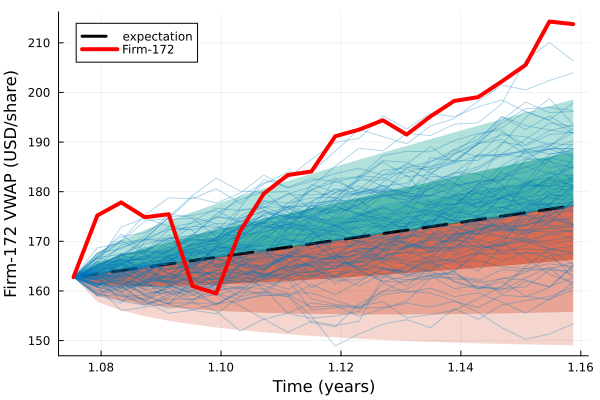

In [18]:
begin
    T = 21
    firm_id = 172
    firm_data = dataset[firm_id];
    start_index = 1049
    stop_index = start_index + T;

    Sₒ = firm_data[start_index, :volume_weighted_average_price];
    μ̂ = parameters[parameters.firm .== firm_id, :μ] |> first;
    σ̂ = parameters[parameters.firm .== firm_id, :σ] |> first;

    model = build(MyGeometricBrownianMotionEquityModel, (
                μ = μ̂, σ = σ̂ ));

    expectation = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
    variance  = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

    X = solve(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
        number_of_paths = 100);

     # draw the plot -
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance_failed[:,2])

    plot(expectation[:,1], expectation[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
    plot!(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.3)
    plot!(X[:,1], firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
        label="Firm-$(firm_id)")

    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(firm_id) VWAP (USD/share)", fontsize=18)
end